# Auditing Federal Contractors Part III
_By [Leon Yin](www.leonyin.org) Last Updated 2018-06-24_

View this notebook in [NBViewer](http://nbviewer.jupyter.org/github/yinleon/us-spending/blob/master/2_ice_money.ipynb?flush=true) or [Github](https://github.com/yinleon/us-spending/blob/master/2_ice_money.ipynb).

The output is availalble publically on [Google Drive](https://docs.google.com/spreadsheets/d/1FnMDVm9rXJrUp8wk-TPL7lIL409ai1Gv9ApeigXa_mM/edit#gid=128424636) and [Github](https://raw.githubusercontent.com/yinleon/us-spending/master/ice_data/data_out/ice_prime_contractors_aggregated.csv).

## ICE Contractor Analysis
Following [my analysis](https://nbviewer.jupyter.org/github/yinleon/us-spending/blob/master/1_analysis_methods.ipynb) of federal contracts to the private prisons CoreCivic and Geo Group, this notebook analyzes publically avaiable contracts from the Immigration and Customs Enforcement Agency (ICE). This analysis uses data downloaded from the new USASpending.gov [dashboard](https://www.usaspending.gov/#/search/1da7f3124d80741313219fd741632538)  filtered on "U.S. Immigration and Customs Enforcement (ICE) | Sub-Agency".

In [2]:
import glob
import datetime
import pandas as pd

In [3]:
# data downloaded from USAspending.gov
input_file_pattern = 'ice_data/data_in/*'

In [4]:
files = glob.glob(input_file_pattern)
files

['ice_data/data_in/all_contracts_subawards_1.csv',
 'ice_data/data_in/all_assistance_prime_transactions_1.csv',
 'ice_data/data_in/all_contracts_prime_transactions_1.csv',
 'ice_data/data_in/all_assistance_subawards_1.csv']

Let's just look at prime contracts today.

In [5]:
df_prime_contracts = pd.read_csv(files[2])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,32,38,46,47,48,49,56,65,78,79,87,106,107,135,136,204) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# there are a lot of columns!
prime_cols = df_prime_contracts.columns
num_cols = len(prime_cols)
print(f"There are {num_cols} columns in this file!\nHere are some of the column names:")
prime_cols.values.tolist()[:20]

There are 258 columns in this file!
Here are some of the column names:


['award_id_piid',
 'modification_number',
 'transaction_number',
 'parent_award_agency_id',
 'parent_award_agency_name',
 'parent_award_id',
 'parent_award_modification_number',
 'federal_action_obligation',
 'base_and_exercised_options_value',
 'current_total_value_of_award',
 'base_and_all_options_value',
 'potential_total_value_of_award',
 'action_date',
 'period_of_performance_start_date',
 'period_of_performance_current_end_date',
 'period_of_performance_potential_end_date',
 'ordering_period_end_date',
 'awarding_agency_code',
 'awarding_agency_name',
 'awarding_sub_agency_code']

That is a lot of columns, here are the definitions of the columns we'll be using here:

## Glossary of fields used in this Analysis with Definitions from USASpending:
`recipient_duns`<br>
The unique identification number for the ultimate parent of an awardee or recipient. Currently the identifier is the 9-digit number maintained by Dun & Bradstreet as the global parent DUNS® number.



`potential_total_value_of_award`<br>
The total amount that could be obligated on a contract. This total includes the base plus options amount. For example, if a recipient is awarded 10M on a base contract with 3 option years at 1M each, the potential award amount is 13M.

`current_total_value_of_award` <br>
The amount of money that the government has promised (obligated) to pay a recipient for a contract. This means the base amount and any exercised options.

`period_of_performance_start_date`<br>
The date that the award begins.

`period_of_performance_potential_end_date`<br>
For procurement, the date on which, for the award referred to by the action being reported if all potential pre-determined or pre-negotiated options were exercised, awardee effort is completed or the award is otherwise ended. Administrative actions related to this award may continue to occur after this date. This date does not apply to procurement indefinite delivery vehicles under which definitive orders may be awarded.

<hr>

Thanks for providing that glossary USASpending, let's do some minor data wrangling and get some summary statistics.

In [7]:
date_cols = ['period_of_performance_start_date', 'period_of_performance_potential_end_date']
for col in date_cols:
    df_prime_contracts[col] = pd.to_datetime(df_prime_contracts[col])

In [8]:
total_spend = df_prime_contracts['current_total_value_of_award'].sum()
potential_spend = df_prime_contracts['potential_total_value_of_award'].sum()
at_stake =  potential_spend - total_spend

num_contractors = len(df_prime_contracts['recipient_duns'].unique())
first_contract = df_prime_contracts['period_of_performance_start_date'].min().strftime('%Y-%m-%d')
print("ICE has invested ${:,.2f} in contracts with {} Prime contractors "
      "since {}.\nICE has ${:,.2f} in potential payouts with active contracts.".format(
          total_spend, num_contractors, first_contract, at_stake))

ICE has invested $76,815,594,715.20 in contracts with 4294 Prime contractors since 2004-10-01.
ICE has $50,376,993,084.23 in potential payouts with active contracts.


Let's sort this data by the contract end date

In [9]:
df_prime_contracts.sort_values(by=['period_of_performance_potential_end_date'], 
                               ascending=False, 
                               inplace=True)

There are typos in the recipient names, so let's use their DUNs IDs for aggregate analysis.<br>
We can create a `lookup_table` containing the latest name and contact info

In [10]:
lookup_cols = [
    'recipient_parent_duns',
    'recipient_parent_name', 
    'recipient_address_line_1', 
    'recipient_address_line_2',
    'recipient_city_name', 
    'recipient_state_code', 
    'recipient_state_name',
    'recipient_zip_4_code', 
    'recipient_congressional_district',
    'recipient_phone_number', 
    'recipient_fax_number'
]

In [11]:
lookup_table = df_prime_contracts.drop_duplicates(
    subset = ['recipient_parent_duns']
)[lookup_cols]

Now let's get how much each company has been rewarded, how much they have the potential to be rewarded, how many awards they're been granted, and when their contracts are finished. This code is chained, and kind of messy. Each line aggreagates by the recipient ID, and performs some sort of agg function, and then sorts the values according to the total of the agg function.

In [12]:
contract_amounts = (df_prime_contracts.groupby(
    ['recipient_parent_duns'])
    ['current_total_value_of_award'].sum()
    .sort_values(ascending=False))

In [13]:
contract_potential = (df_prime_contracts.groupby(
    ['recipient_parent_duns'])
    ['potential_total_value_of_award'].sum()
    .sort_values(ascending=False))

In [14]:
num_awards = (df_prime_contracts.groupby(
    ['recipient_parent_duns'])
    ['current_total_value_of_award'].count()
    .sort_values(ascending=False))

In [15]:
contract_enddate = (df_prime_contracts[
    ~df_prime_contracts['period_of_performance_potential_end_date'].isnull()]
    .groupby(['recipient_parent_duns'])
    ['period_of_performance_potential_end_date'].max()
    .sort_values(ascending=False))

In [16]:
contract_startdate = (df_prime_contracts[
    ~df_prime_contracts['period_of_performance_start_date'].isnull()]
    .groupby(['recipient_parent_duns'])
    ['period_of_performance_start_date'].min()
    .sort_values(ascending=False))

For context, let's see what kinds of services each of these companies provide by counting the most frequent words in service descriptions per contractor.

In [24]:
from collections import Counter
from nltk.corpus import stopwords

In [142]:
def count_words(row, counter, sw):
    '''
    Splits sentences, casts words to lowercase, and counts all words that aren't in stopwords (sw)
    '''
    row_clean = str(row).replace('-', ' ').replace('/', ' ').lower()
    counter.update([w for w in row_clean.split() if w not in sw])

In [99]:
sw = stopwords.words('English')

In [143]:
top_words = []
for dun_id_, df_ in df_prime_contracts.groupby('recipient_parent_duns'):
    word_counter_ = Counter()
    df_['product_or_service_code_description'].apply(count_words, args=(word_counter_, sw,))
    
    top_words_ = ', '.join([w for w, c in word_counter_.most_common(5)])
    d_ = dict(top_words_from_serv_desc  = top_words_,
              recipient_parent_duns = dun_id_)
    
    top_words.append(d_)
    
top_words_per_service_description = pd.DataFrame(top_words)

We can join them all together using this craziness below:

In [144]:
output = (contract_amounts.reset_index()
          .merge(
            num_awards.reset_index(), on='recipient_parent_duns')
          .merge(
            contract_potential.reset_index(), on='recipient_parent_duns')
          .merge(
            contract_enddate.reset_index(), on='recipient_parent_duns')
          .merge(
            contract_startdate.reset_index(), on='recipient_parent_duns')
          .merge(
            top_words_per_service_description, on='recipient_parent_duns')
          .merge(
            lookup_table))

The last merge above is the look_up table, containing metadata for each recipient.<br>
Let's change some of the aggregate column names to be more decriptive:

In [145]:
remapping = {
    'current_total_value_of_award_x' : 'current_total_value_of_awards_USD',
    'current_total_value_of_award_y' : 'number_of_prime_awards_USD',
    'potential_total_value_of_award' : 'potential_total_value_of_awards',
    'period_of_performance_potential_end_date' : 'last_contract_end_date',
    'period_of_performance_start_date' : 'first_contract_start_date'
}

In [146]:
output.columns = [remapping.get(c, c) for c in output.columns]

Let's timestamp when this file was made.

In [147]:
output['analysis_date'] = datetime.datetime.now() # when was this file made?
output['raw_data_download_date'] = datetime.datetime(2018,6,24) # when was raw data downloaded?

And lastly, let's re-order the columns so they're readable

In [114]:
order_cols = [
    'recipient_parent_name',
    'top_words_from_serv_desc',
    'number_of_prime_awards',
    'current_total_value_of_awards_USD',
    'potential_total_value_of_awards',
    'first_contract_start_date',
    'last_contract_end_date',
    'recipient_address_line_1',
    'recipient_address_line_2',
    'recipient_city_name', 
    'recipient_state_code', 
    'recipient_state_name',
    'recipient_zip_4_code',
    'recipient_congressional_district',
    'recipient_phone_number', 
    'recipient_fax_number',
    'analysis_date',
    'raw_data_download_date'
]

Here is the output:

In [ ]:
for contractor, df_ in output.groupby('recipient_parent_name'):
    df_['number_of_pride_awards'].sum()
    df_['current_total_value_of_awards_USD'].sum()
    df_['potential_total_value_of_awards'].sum()

In [149]:
output[order_cols].head(50)

,recipient_parent_name,top_words_from_serv_desc,number_of_prime_awards,current_total_value_of_awards_USD,potential_total_value_of_awards,first_contract_start_date,last_contract_end_date,recipient_address_line_1,recipient_address_line_2,recipient_city_name,recipient_state_code,recipient_state_name,recipient_zip_4_code,recipient_congressional_district,recipient_phone_number,recipient_fax_number,analysis_date,raw_data_download_date
0,BATTELLE MEMORIAL INSTITUTE INC,"oper, govt, r&d, goco, facilities",1,2.258840e+10,2.258840e+10,2016-05-27 00:00:00,2017-09-30,902 BATTELLE BLVD,NaN,RICHLAND,WA,WASHINGTON,993521873,NaN,NaN,NaN,2018-06-24 21:06:38.085717,2018-06-24
1,SPECTRUM SECURITY SERVICES INC.,"guard, housekeeping, services",128,1.731890e+10,1.902971e+10,2008-09-08 00:00:00,2018-12-11,13967 HIGHWAY 94 STE 101,NaN,JAMUL,CA,CALIFORNIA,919353232,50,NaN,NaN,2018-06-24 21:06:38.085717,2018-06-24
2,CSI AVIATION SERVICES INC.,"travel, air, passenger, transportation, reloca...",63,5.897378e+09,7.426944e+09,2009-03-31 00:00:00,2018-06-30,3700 RIO GRANDE BLVD NW,NaN,ALBUQUERQUE,NM,NEW MEXICO,871072876,01,5057619000,5053427377,2018-06-24 21:06:38.085717,2018-06-24
3,INGENESIS INC.,"medical, general, health, care",20,3.530665e+09,4.874056e+09,2012-07-16 00:00:00,2018-07-15,10231 KOTZEBUE ST,NaN,SAN ANTONIO,TX,TEXAS,782174430,21,2103660033,2105684582,2018-06-24 21:06:38.085717,2018-06-24
4,THE GEO GROUP INC,"guard, housekeeping, support, services, program",115,3.335807e+09,1.663010e+10,2007-06-01 00:00:00,2029-10-11,621 NW 53RD ST STE 700,NaN,BOCA RATON,FL,FLORIDA,334878242,22,5619997359,5619997648,2018-06-24 21:06:38.085717,2018-06-24
5,PHACIL INC.,"telecom, help, desk",47,2.889115e+09,3.027381e+09,2012-09-10 00:00:00,2018-09-09,800 N GLEBE RD STE 700,NaN,ARLINGTON,VA,VIRGINIA,222032149,8,7035261800,7033662900,2018-06-24 21:06:38.085717,2018-06-24
6,SPECTRUM SECURITY SERVICES INC.,"housekeeping, guard",13,1.864530e+09,1.997933e+09,2011-12-21 00:00:00,2016-02-29,13967 HIGHWAY 94 STE 101,NaN,JAMUL,CA,CALIFORNIA,919353232,52,NaN,NaN,2018-06-24 21:06:38.085717,2018-06-24
7,ASSET PROTECTION & SECURITY SERVICES L.P.,"guard, housekeeping, oper, govt, misc",19,1.400854e+09,1.633666e+09,2009-09-30 00:00:00,2018-09-30,5502 BURNHAM DR,NaN,CORPUS CHRISTI,TX,TEXAS,784133787,27,3619061552,3619061844,2018-06-24 21:06:38.085717,2018-06-24
8,WIDEPOINT CORPORATION,"support, professional:, program, management",25,1.318187e+09,5.204160e+09,2015-04-09 00:00:00,2018-12-08,7926 JONES BRANCH DR STE 520,NaN,MC LEAN,VA,VIRGINIA,221023371,11,7033495644,7038483560,2018-06-24 21:06:38.085717,2018-06-24
9,TRAILBOSS ENTERPRISES INC.,"housekeeping, facilities, operations, support,...",13,1.266682e+09,3.871661e+09,2012-06-01 00:00:00,2018-09-30,201 EAST 3RD AVE,NaN,ANCHORAGE,AK,ALASKA,995012503,00,9073388243,9073380869,2018-06-24 21:06:38.085717,2018-06-24


There are still a lot of duplicates, future work will be fuzzy matching these accounts.<br>
Let's save this as a csv.

In [150]:
outfile = 'ice_data/data_out/ice_prime_contractors_aggregated.csv'
output[order_cols].to_csv(outfile, index=False)

## Plotting Top Contractors

In [209]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

In [201]:
millnames = ['',' K',' M',' B',' T']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

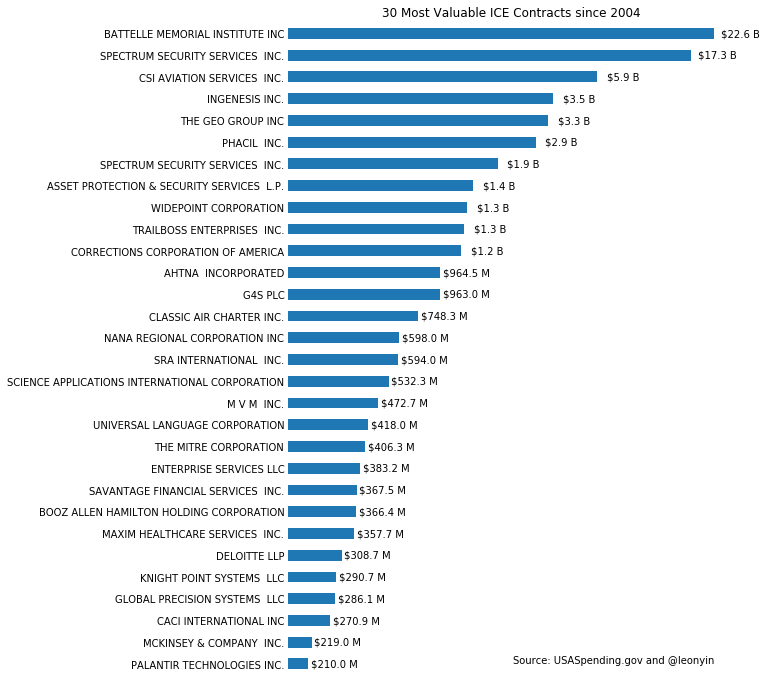

In [247]:
ax = output.head(30).plot(x='recipient_parent_name', 
                          y='current_total_value_of_awards_USD', 
                          kind='barh',
                          logx=True,
                          figsize=(8,12),
                          title= "30 Most Valuable ICE Contracts since 2004",
                          legend=False)
# annotate each bar
for rect in ax.patches: 
    width = rect.get_width()
    ax.text(1.35*rect.get_width(), rect.get_y()+ 0.5 * rect.get_height(),
            '$' + millify(width),
            ha='center', va='center')

# remove boarder    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remoce axis titles
ax.set_xlabel("")
ax.set_ylabel("")

# remove ticks
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_ticks([])
ax.invert_yaxis();

ax.annotate('Source: USASpending.gov and @leonyin', 
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 10), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom');